In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn
import yt
from astropy import units as u, constants  as c
from unyt import cm, s, erg, sr
pc = c.pc.cgs.value
kB  = c.k_B.cgs.value
Msun = c.M_sun.cgs.value
G = c.G.cgs.value
Myr = u.Myr.in_units("s")
%matplotlib inline

        Use to() instead. [warnings]


In [45]:
def load_CIE_data():
    # Collisional ionisation equilibrium (CIE) abundances from Gnat & Sternberg (2007, ApJS, 168, 213)
    CIE_data = np.loadtxt("CIE-abundances-gs07.txt")
    return CIE_data

def get_ion_abundance(CIE_data, ion, T):
    ion_list = dict([('HI',  1),  ('HII',  2), 
                     ('HeI', 3),  ('HeII', 4),  ('HeIII', 5),
                     ('NI',  13), ('NII',  14), 
                     ('OI',  21), ('OII',  22), ('OIII',  23), 
                     ('SI',  69), ('SII',  70), ('SIII',  71)])
    
    ion_index = ion_list[ion]
    ion_temps = data[:,0]
    T_index = np.searchsorted(ion_temps, T)
    abundance = np.zeros(T.size)
    dT = np.zeros(T.size)

    # If the requested temperature is outside of the tabulated range, we return the first or last value from the table, as appropriate
    # Otherwise, we calculate the value using linear interpolation
    
    mask1 = (T_index >= ion_temps.size)
    mask2 = (T_index == 0)
    mask3 = (~mask1 & ~mask2)

    abundance[mask1] = data[-1, ion_index]
    abundance[mask2] = data[0,  ion_index]
    dT[mask3] = ion_temps[T_index[mask3]] - ion_temps[T_index[mask3]-1]
    abundance[mask3] = data[T_index[mask3]-1,ion_index] + (data[T_index[mask3],ion_index] - data[T_index[mask3]-1,ion_index]) * ((T[mask3] - ion_temps[T_index[mask3]-1]) / dT[mask3])
    
    return abundance

def compute_emissivity(CIE_data, ion, transition, density, T):
    # Current we assume we're dealing with solar metallicty gas. Could be modified to take individual elemental
    # abundances or total metallicity as an input parameter, but that doesn't seem necessary right now
    solar_abundances = dict([('H', 1.0), ('He', 0.1), ('N', 6.03e-5), ('O', 4.57e-4), ('S', 1.38e-5)])

    # Check whether the transition wavelength we've passed in is one we're expecting to see
    # Note: if the value is a long way off from what it expects, PyNeb will also produce an error
    known_transitions = (3726, 3729, 5007, 6300, 6583, 6717, 6731, 9069, 9531) 
    if transition not in known_transitions:
        print("Unexpected transition wavelength: ", transition)
    
    if ion[0:2] == 'He':
        element = 'He'
        charge_state = len(ion) - 2
    else:
        element = ion[0]
        charge_state = len(ion) - 1  

    # Get number density of emitting ion
    elemental_abundance = solar_abundances[element]
    ion_fraction = get_ion_abundance(data, ion, T)
    ion_density = elemental_abundance * ion_fraction * density

    # Get electron number density. Currently, we also assume CIE here but we could alternatively extract this from the FLASH
    # simulation snapshots and pass it in as an additional parameter.
    #
    # Note: we include contribution from helium here, but not from metals -- this is a <1% effect, hence unlikely to be important
    electron_fraction = get_ion_abundance(data, 'HII', T) + 0.1 * get_ion_abundance(data, 'HeII', T) + 0.2 * get_ion_abundance(data, 'HeIII', T)
    electron_density = electron_fraction * density

    atom = pn.Atom(element, charge_state)
    
    # This computes the emission coefficient (units: erg cm^3 s^-1) for the transition from the specified ion at the specified wavelength
    # To compute the emissivity (units: erg cm^-3 s^-1), we then simply multiply by the ion density and the electron density
    emission_coeff = atom.getEmissivity(tem=T, den=density, wave=transition)
    emissivity = emission_coeff * ion_density * electron_density
    
    return emissivity


yt : [INFO     ] 2025-04-09 12:36:57,399 Parameters: current_time              = 340597785179995.1
yt : [INFO     ] 2025-04-09 12:36:57,401 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-04-09 12:36:57,402 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-04-09 12:36:57,403 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-04-09 12:36:57,404 Parameters: cosmological_simulation   = 0


SILCC_hdf5_plt_cnt_1080


yt : [INFO     ] 2025-04-09 12:37:16,883 xlim = -1018354206519309369344.000000 524645793480690630656.000000
yt : [INFO     ] 2025-04-09 12:37:16,885 ylim = -1234351637223705149440.000000 308648362776294916096.000000
yt : [INFO     ] 2025-04-09 12:37:16,889 xlim = -1018354206519309369344.000000 524645793480690630656.000000
yt : [INFO     ] 2025-04-09 12:37:16,890 ylim = -1234351637223705149440.000000 308648362776294916096.000000
yt : [INFO     ] 2025-04-09 12:37:16,893 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800
yt : [INFO     ] 2025-04-09 12:37:17,921 xlim = -1018354206519309369344.000000 524645793480690630656.000000
yt : [INFO     ] 2025-04-09 12:37:17,923 ylim = -1234351637223705149440.000000 308648362776294916096.000000
yt : [INFO     ] 2025-04-09 12:37:17,925 xlim = -1018354206519309369344.000000 524645793480690630656.000000
yt : [INFO     ] 2025-04-09 12:37:17,926 ylim = -1234351637223705149440.000000 308648362776294916096.000000
yt : [INFO     ] 202

Plotting OI_6300...
OI_6300: ion=OI, λ=6300, max(em_table)=4.38e-26
Plotting OII_3726...
OII_3726: ion=OII, λ=3726, max(em_table)=3.71e-24


/home/neutrino/anaconda3/envs/yt/lib/python3.13/site-packages/pyneb/core/pynebcore.py:1781: RuntimeWarning: invalid value encountered in divide
  self._critDensity = sum_A / q.sum(axis=1)


Plotting OII_3729...
OII_3729: ion=OII, λ=3729, max(em_table)=5.39e-24


/home/neutrino/anaconda3/envs/yt/lib/python3.13/site-packages/pyneb/core/pynebcore.py:1781: RuntimeWarning: invalid value encountered in divide
  self._critDensity = sum_A / q.sum(axis=1)


Plotting OIII_5007...
OIII_5007: ion=OIII, λ=5007, max(em_table)=2.03e-23
Plotting NII_6583...
NII_6583: ion=NII, λ=6583, max(em_table)=3.70e-25
Plotting SII_6717...
SII_6717: ion=SII, λ=6717, max(em_table)=8.58e-26
Plotting SII_6731...
SII_6731: ion=SII, λ=6731, max(em_table)=6.16e-26
Plotting SIII_9069...
SIII_9069: ion=SIII, λ=9069, max(em_table)=2.12e-25
Plotting SIII_9531...
SIII_9531: ion=SIII, λ=9531, max(em_table)=5.23e-25


/tmp/ipykernel_739191/1071448343.py:75: RuntimeWarning: invalid value encountered in divide
  ratio_map = np.where(em_storage[denom_label] > 0, em_storage[num_label] / em_storage[denom_label], np.nan)
/tmp/ipykernel_739191/1071448343.py:75: RuntimeWarning: invalid value encountered in divide
  ratio_map = np.where(em_storage[denom_label] > 0, em_storage[num_label] / em_storage[denom_label], np.nan)
/tmp/ipykernel_739191/1071448343.py:75: RuntimeWarning: invalid value encountered in divide
  ratio_map = np.where(em_storage[denom_label] > 0, em_storage[num_label] / em_storage[denom_label], np.nan)


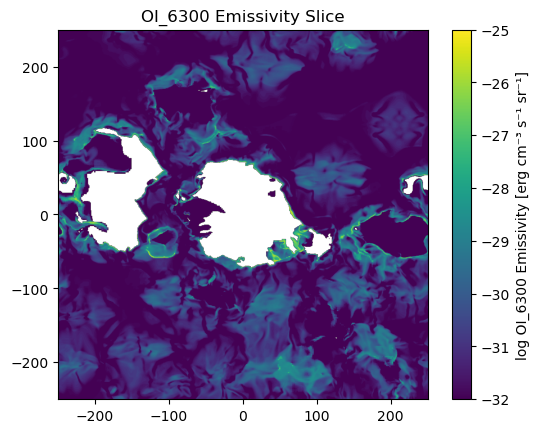

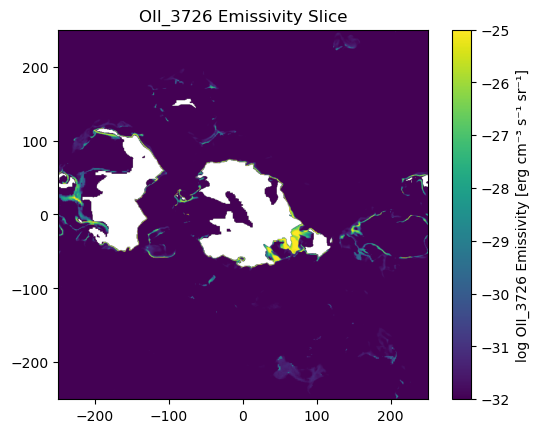

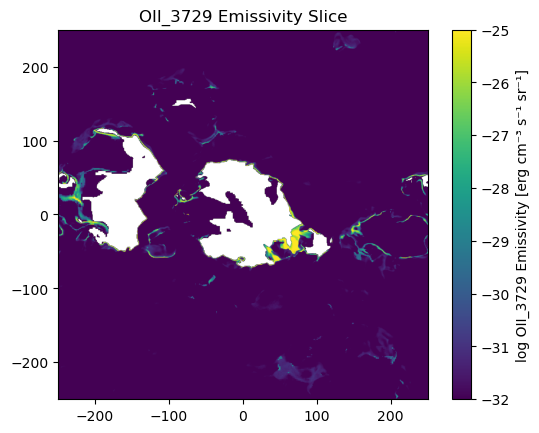

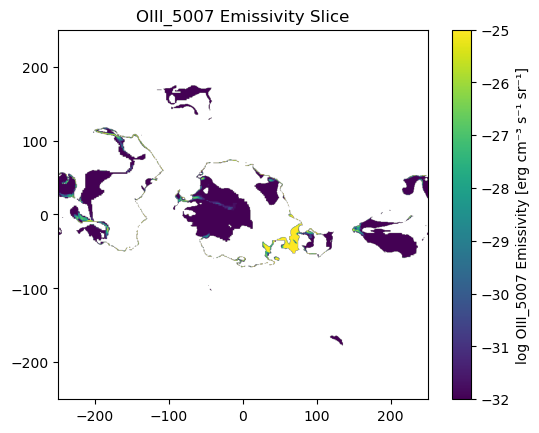

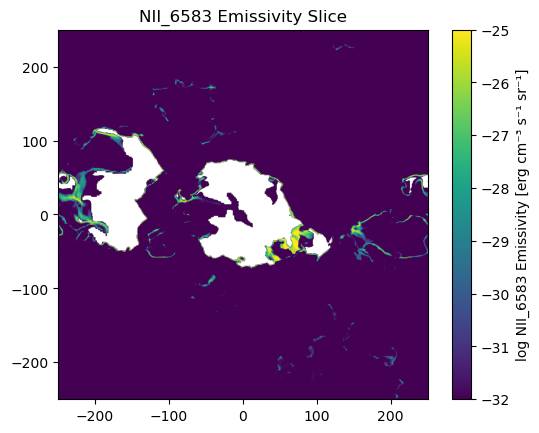

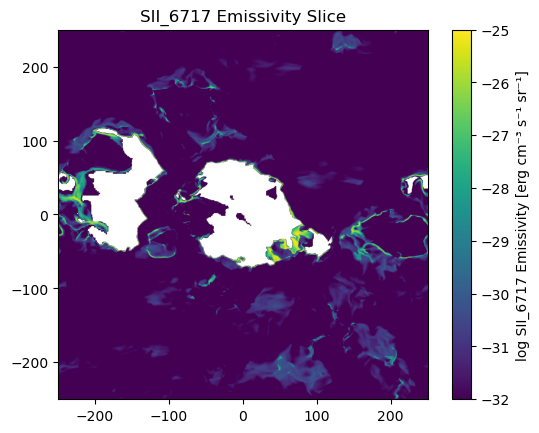

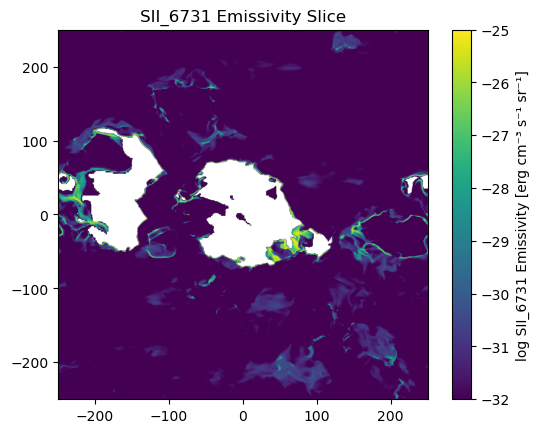

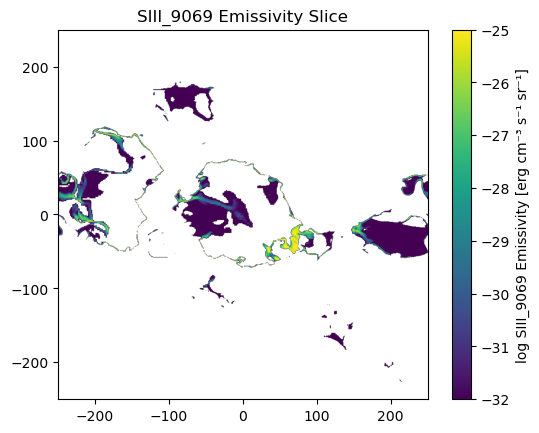

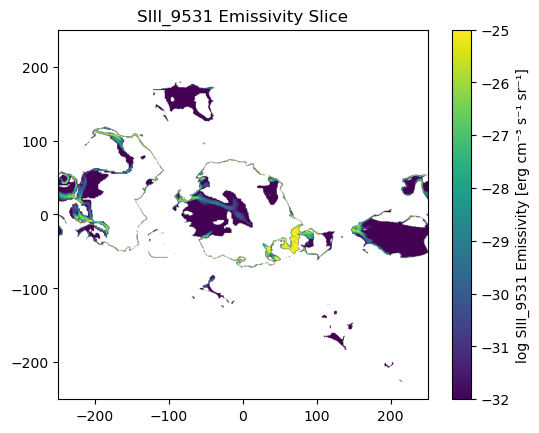

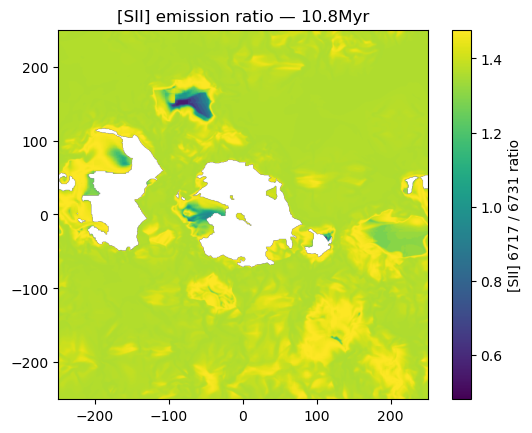

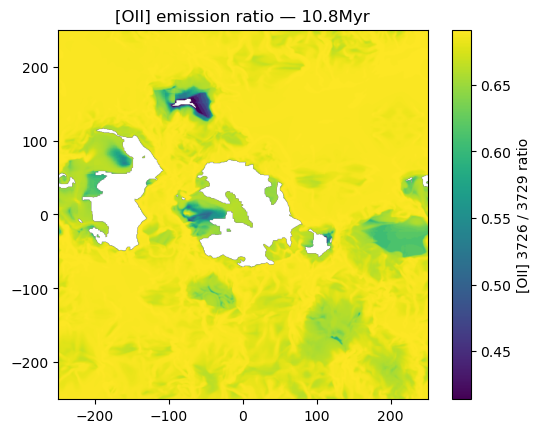

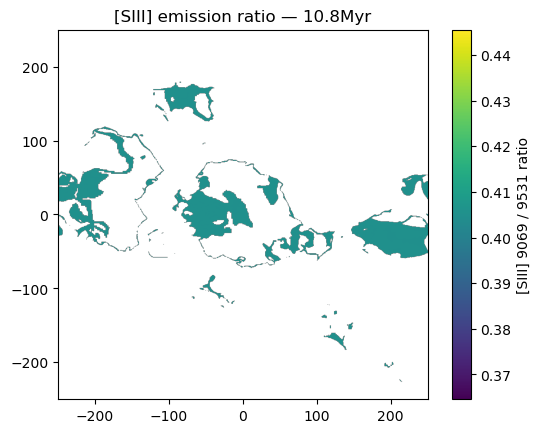

In [58]:
ctr = [-80*pc, -150*pc, 0]
files = ["SILCC_hdf5_plt_cnt_1080"]
names = ["10.8Myr"]

# Define all transitions once
transitions = {
    "OI_6300":    ("OI", 6300),
    "OII_3726":   ("OII", 3726),
    "OII_3729":   ("OII", 3729),
    "OIII_5007":  ("OIII", 5007),
    "NII_6583":   ("NII", 6583),
    "SII_6717":   ("SII", 6717),
    "SII_6731":   ("SII", 6731),
    "SIII_9069":  ("SIII", 9069),
    "SIII_9531":  ("SIII", 9531),
}

for f, name in zip(files, names):
    print(f)
    ds = yt.load("data/"+f)

    datn = np.array(yt.SlicePlot(ds, "z", ("gas","number_density"), center=ctr)
                    .data_source.to_frb((500, "pc"), 800)[("gas", "number_density")])
    datT = np.array(yt.SlicePlot(ds, "z", ("gas","temperature"), center=ctr)
                    .data_source.to_frb((500, "pc"), 800)[("gas", "temperature")])

    min_n = np.log10(np.min(datn))
    max_n = np.log10(np.max(datn))
    min_T = np.log10(np.min(datT))
    max_T = np.log10(np.max(datT))

    n_grid = np.logspace(min_n, max_n, 100)
    T_grid = np.logspace(min_T, max_T, 100)
    log_n_values = np.log10(n_grid)
    log_T_values = np.log10(T_grid)

    data = load_CIE_data()

    # Digitize slices once
    log_datn = np.log10(datn)
    log_datT = np.log10(datT)
    n_idx = np.clip(np.digitize(log_datn, log_n_values) - 1, 0, len(log_n_values) - 1)
    T_idx = np.clip(np.digitize(log_datT, log_T_values) - 1, 0, len(log_T_values) - 1)

    # Store emission maps for specific lines
    em_storage = {}

    # Plot each emission line
    for label, (ion, wavelength) in transitions.items():
        print(f"Plotting {label}...")
        #table for each transition because different wavelengths 
        em_table = compute_emissivity(data, ion=ion, transition=wavelength, density=n_grid, T=T_grid)
        em_maps = em_table[n_idx, T_idx]
        print(f"{label}: ion={ion}, λ={wavelength}, max(em_table)={np.max(em_table):.2e}")

        plt.figure()
        em_plot = np.log10(np.where(em_maps > 0, em_maps, np.nan))
        #em_plot = (np.where(em_maps > 0, em_maps, np.nan))
        #plt.imshow(em_plot, origin="lower", extent=[-250, 250, -250, 250])
        plt.imshow(em_plot, origin="lower", extent=[-250, 250, -250, 250], vmin=-32, vmax=-25)
        #plt.imshow(np.log10(em_maps), origin="lower", extent=[-250, 250, -250, 250])
        plt.colorbar(label=f"log {label} Emissivity [erg cm⁻³ s⁻¹ sr⁻¹]")
        plt.title(f"{label} Emissivity Slice")
        plt.savefig(f"slc_{label}_{name}.pdf")
        #plt.close()
        
        # Inside your transition loop:
        em_storage[label] = em_maps

line_ratios = [("SII_6717", "SII_6731", "SII"),
    ("OII_3726", "OII_3729", "OII"),
    ("SIII_9069", "SIII_9531", "SIII"),]

for num_label, denom_label, ion_label in line_ratios:
    ratio_map = np.where(em_storage[denom_label] > 0, em_storage[num_label] / em_storage[denom_label], np.nan)
    
    plt.figure()
    plt.imshow(ratio_map, origin="lower", extent=[-250, 250, -250, 250])
    #plt.imshow(ratio_map, origin="lower", extent=[-250, 250, -250, 250], vmin=0.4, vmax=1.6)
    plt.colorbar(label=f"[{ion_label}] {num_label[-4:]} / {denom_label[-4:]} ratio")
    plt.title(f"[{ion_label}] emission ratio — {name}")
    plt.savefig(f"slcratio_{ion_label}_{name}.pdf")



In [ ]:
#ohne loop
ctr = [-80*pc, -150*pc, 0]
files = ["SILCC_hdf5_plt_cnt_1080"]
names = ["10.8Myr"]

for f, name in zip(files, names):
    print(f)
    ds = yt.load("data/"+f)

    datn = np.array(yt.SlicePlot(ds, "z", ("gas","number_density"), center=ctr).data_source.to_frb((500, "pc"), 800)[("gas", "number_density")])
    datT = np.array(yt.SlicePlot(ds, "z", ("gas","temperature"), center=ctr).data_source.to_frb((500, "pc"), 800)[("gas", "temperature")])

    min_n = np.log10(np.min(datn))
    max_n = np.log10(np.max(datn))
    min_T = np.log10(np.min(datT))
    max_T = np.log10(np.max(datT))

    n_grid = np.logspace(min_n, max_n, 100)
    T_grid = np.logspace(min_T, max_T, 100)
    log_n_values = np.log10(n_grid)
    log_T_values = np.log10(T_grid)

    data = load_CIE_data()
    em_table = compute_emissivity(data, ion="OIII", transition=5007, \
                                  density=np.logspace(min_n,max_n,100), T=np.logspace(min_T, max_T,100))
    print(em_O3.shape)

    # plot table
    plt.figure() 
    plt.imshow(np.log10(em_table))
    plt.colorbar()
    plt.title("Full Emissivity Table")

    # Convert slices to log10 scale
    log_datn = np.log10(datn)
    log_datT = np.log10(datT)

    # Find nearest index in the emissivity table
    n_idx = np.clip(np.digitize(log_datn, log_n_values) - 1, 0, len(log_n_values) - 1)
    T_idx = np.clip(np.digitize(log_datT, log_T_values) - 1, 0, len(log_T_values) - 1)

    # Map emissivity from table to each pixel
    em_O3 = em_table[n_idx, T_idx]

    # Plot
    plt.figure() 
    plt.imshow(np.log10(em_O3), origin="lower", extent=[-250, 250, -250, 250])
    plt.colorbar(label="log OIII 5007Å Emissivity [erg cm⁻³ s⁻¹ sr⁻¹]")
    plt.title("OIII Emissivity Slice")
    plt.savefig(f"slice_plot_{name}.pdf")
